In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import Models as M

In [3]:
def printScore(file):
    directory = '/home/thire399/Documents/School/DC-MasterThesis-2023/Data/Loss_chest_xray/'
    os.chdir(directory)
    train = torch.load('train_loss' + file + '.pt').tolist()
    val = torch.load('val_loss' + file + '.pt').tolist()
    print('min train accuracy {0}\nmin val accuracy   {1}\nAfter {2} epochs'.format(
                    np.round(1-min(train),3 ),
                    np.round(1-min(val), 3),
                    val.index(min(val))))
    return None

In [14]:
def get_epochs(file, path):
    idk = str(file[5:])
    val = torch.load(f'Data/Loss_{path}/val_loss' + file[5:] + '.pt').tolist()
    return val.index(min(val))+1
get_epochs(f'model128x128FullResNet20230416-155009', 'Alzheimer_MRI')


22

In [9]:
import torch
from torchvision import datasets, transforms

# Set the path where the MNIST data will be stored
data_path = "./mnist_data"

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image data
])

# Download and load the MNIST training set
train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)

# Filter the training dataset to include only class 0 and 1
train_dataset_filtered = torch.utils.data.Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label == 0 or label == 1])
train_data = torch.stack([data for data, label in train_dataset_filtered])
train_labels = torch.tensor([label for _, label in train_dataset_filtered])
sorted_indices = torch.argsort(train_labels)
train_data = train_data[sorted_indices]
train_labels = train_labels[sorted_indices]

torch.Size([12665, 1, 28, 28])


In [14]:
sorted_indices = torch.argsort(train_labels)
train_data = train_data[sorted_indices]
train_labels = train_labels[sorted_indices]

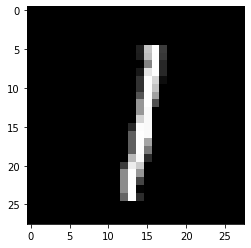

In [25]:
plt.imshow(train_data[7000][0], cmap = 'gray')
plt.show()

## TESTING

In [20]:
def Gen_Y(size):
    if size % 2 != 0:
        return None
    class_0 = torch.tensor(np.asarray([0]*int(size/2)))
    class_1 = torch.tensor(np.asarray([1]*int(size/2)))
    return torch.cat((class_0, class_1))


#dataset = 'Alzheimer_MRI'
dataset = 'MNIST'
datasetType = ''
S_x = torch.rand(40, 1, 128, 128)
S_y = Gen_Y(S_x.shape[0])

T_x = torch.load(f'Data/Proccesed/{dataset}/'+ datasetType +'trainX.pt')
T_y = torch.load(f'Data/Proccesed/{dataset}/'+ datasetType +'trainY.pt')

Schange_class_index = torch.argmax(S_y).item()
Tchange_class_index = torch.argmax(T_y).item()
print(Schange_class_index)
T_DataX = torch.tensor(T_x[Tchange_class_index:])
T_DataY = torch.tensor(T_y[Tchange_class_index:])
S_DataX = torch.tensor(S_x[Schange_class_index:])
S_DataY = torch.tensor(S_y[Schange_class_index:])
T_DataX2 = torch.stack([T_x[i] for i in range(len(T_y)) if T_y[i] == 1])
T_DataY2 = torch.stack([T_y[i] for i in range(len(T_y)) if T_y[i] == 1])
S_DataX2 = torch.stack([S_x [i] for i in range(len(S_y)) if S_y[i] == 1])
S_DataY2 = torch.stack([S_y [i] for i in range(len(S_y)) if S_y[i] == 1])
print(S_DataX.shape)
print(torch.sum(torch.sum(torch.eq(S_DataX, S_DataX2))) == torch.sum(torch.sum(torch.eq(S_DataX, S_DataX))))



20
torch.Size([20, 1, 128, 128])
tensor(True)


# Captum

In [13]:
import captum.attr
import captum
import os
import torch
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
from torchvision import models
import Models as M
import gc
import torch.nn as nn
os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023')
#del model 
gc.collect()
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
#dataSet = 'chest_xray'
dataSet = 'Alzheimer_MRI'
#datasetType = '01PercentDistribution'
#datasetType = '10PercentRandom'
#datasetType = '1PercentDistribution'
datasetType = ''
#model = models.alexnet(pretrained = False)
#model.classifier[6] = nn.Linear(in_features=4096, out_features = 2, bias=True)
model = models.resnet50(pretrained = False)
model.fc = nn.Linear(in_features = 2048, out_features = 1, bias=True)
model.load_state_dict(torch.load(f'Data/Loss_{dataSet}/model128x128FullResNet20230416-155009'))
data = torch.load(f'Data/Proccesed/{dataSet}/{datasetType}trainX.pt')
y = torch.load(f'Data/Proccesed/{dataSet}/{datasetType}trainY.pt')
model.to(device)
model.eval()
DeepLift = captum.attr.DeepLift(model)
input1 = data[0].unsqueeze(0)
input2 = data[600].unsqueeze(0)
input1 = input1.repeat(1,3,1,1).float()
input2 = input2.repeat(1,3,1,1).float()
print(input1.shape)

attrDeepLift1 = DeepLift.attribute(input1.to(device), target = 0)
attrDeepLift2 = DeepLift.attribute(input2.to(device), target = 1)

vis_types = ["heat_map", "original_image"]
vis_signs = ["absolute_value", "absolute_value"]

fig, ax = plt.subplots(1, 2, figsize = ( 10,10))
fig1, ax1 = viz.visualize_image_attr(attrDeepLift1[0][1].squeeze().unsqueeze(2).cpu().detach().numpy()+1e-10,
                                        plt_fig_axis = (fig, ax[0]),
                                        cmap = 'twilight',
                                        show_colorbar = True,
                                        title = str(y[0].item()),
                                        use_pyplot = False)
fig2, ax2 = viz.visualize_image_attr(attrDeepLift2[0][1].squeeze().unsqueeze(2).cpu().detach().numpy()+1e-10,
                                        plt_fig_axis = (fig, ax[1]),
                                        cmap = 'twilight',
                                        show_colorbar = True,
                                        title = str(y[1].item()),
                                        use_pyplot = False)
plt.tight_layout()
plt.show()

torch.Size([1, 3, 128, 128])


RuntimeError: A Module ReLU(inplace=True) was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

# Size tool 

label 0
torch.Size([1, 128, 128])
torch.Size([4032, 1, 128, 128])
Distribution torch.Size([4032]) tensor(2016, dtype=torch.int32)


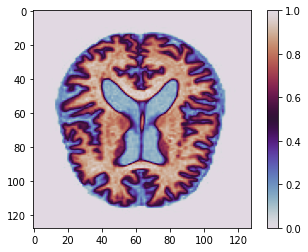

In [6]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os
index = 0
dataset = 'Alzheimer_MRI'
#dataset = 'chest_xray'
#datasetType = '01PercentDistribution'
#datasetType = '10PercentRandom'
#datasetType = '10PercentDistribution'
datasetType = ''
os.chdir(os.getcwd())
data = torch.load(f'Data/Proccesed/{dataset}/'+ datasetType +'trainX.pt')
y = torch.load(f'Data/Proccesed/{dataset}/'+ datasetType +'trainY.pt')
print(f'label {y[index]}')
print(data[index].shape)
print(data.shape)
#print(data[index])
plt.imshow(data[index][0], cmap = 'twilight')
plt.colorbar()
print('Distribution', y.shape, sum(y))
#print(torch.max(data[0]), torch.min(data[0]))
plt.show()
#from torchvision import models
#import torch.nn as nn
#import torch
#model = models.resnet50(pretrained = False)
#
#model.fc = nn.Linear(in_features = 2048, out_features = 1, bias=True)
#model.fc.add_module('sigmoid', nn.Sigmoid())
#data = data.repeat(1,3,1,1)
#Set = torch.utils.data.TensorDataset(data, y)
#Loader = torch.utils.data.DataLoader(Set,
#                                        batch_size = 10,
#                                        shuffle = True,
#                                        num_workers = 0)
#for i, (dd, yy) in enumerate(Loader):
#    out = model(data.type(torch.float32))
#    out = nn.Sigmoid()(out)
#    break
##out = out.clamp(min = 0)
#
#for i in range(10):
#    print(out[i], yy[i].item())



torch.Size([122, 1, 28, 28])


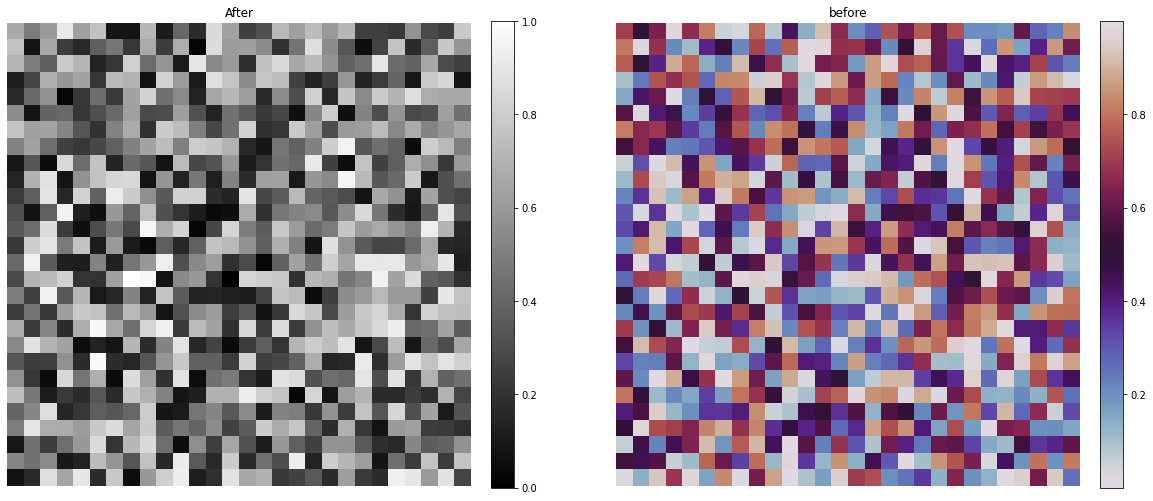

In [28]:
def min_max_normalization(images_tensor): # Calculate the minimum and maximum values across all images 
    min_value = torch.min(images_tensor) 
    max_value = torch.max(images_tensor) # Normalize the tensor using min-max normalization 
    normalized_tensor = (images_tensor - min_value) / (max_value - min_value) 
    return normalized_tensor

os.chdir(os.getcwd())
img = 10
customLabel = 'MNIST'#'GMK500S402After'
dataset = 'MNIST'
x = torch.load(f'Data/Synthetic_{dataset}/{customLabel}X.pt')
y = torch.load(f'Data/Synthetic_{dataset}/{customLabel}BeforeX.pt')
#d = torch.load(f'Data/Synthetic_Alzheimer_MRI/{customLabel}testDistance.pt')
print(x.shape)
y = y[img][0].detach().cpu().numpy()
x = min_max_normalization(x[img][0]).detach().cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize = (20, 20))
ax[0].set_title('After')
ax[0].axis('off')
idk1 = ax[0].imshow(x, cmap='gray')
ax[1].set_title('before')
ax[1].axis('off')
idk2 = ax[1].imshow(y, cmap='twilight')#'twilight')
plt.colorbar(idk1, fraction=0.046, pad=0.04)
plt.colorbar(idk2, fraction=0.046, pad=0.04)
plt.show()
temp = y == x
# print('is same', sum(sum(temp)))
# print(np.min(x), np.max(x))
# plt.figure(figsize=(50, 20))
# plt.ylabel('Loss (Distance)')
# plt.xlabel = ('Iterations (k*t)')
# plt.plot(range(len(d)), d)
# plt.grid()
# plt.show()

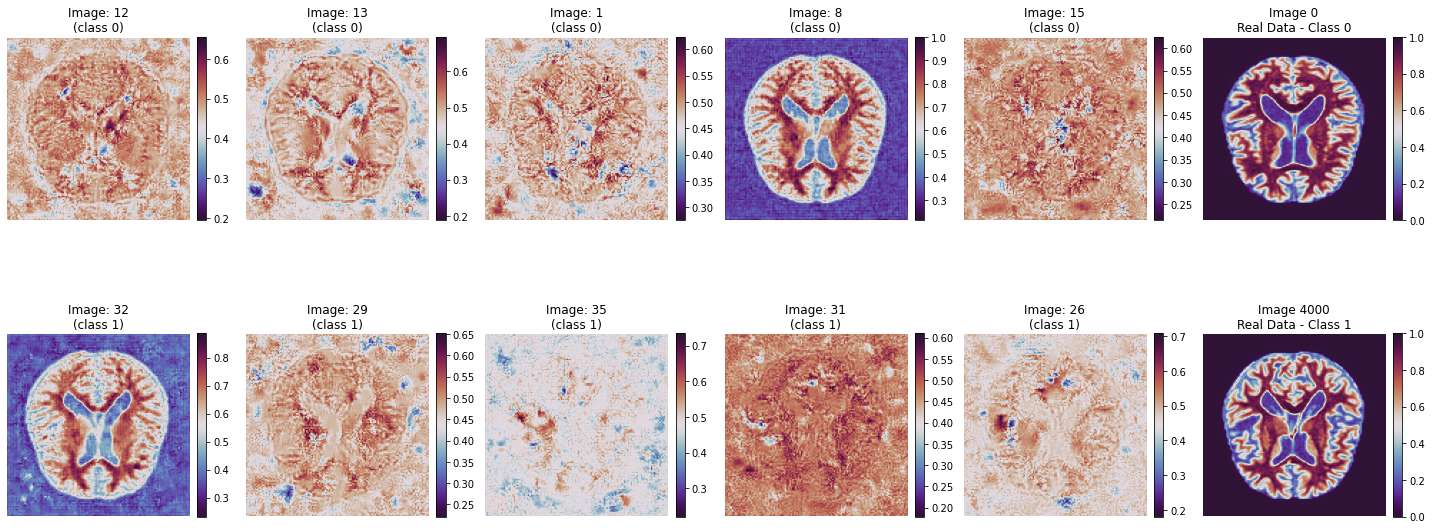

In [9]:
import random
random.seed(0)
def min_max_normalization(images_tensor): # Calculate the minimum and maximum values across all images 
    min_value = torch.min(images_tensor) 
    max_value = torch.max(images_tensor) # Normalize the tensor using min-max normalization 
    normalized_tensor = (images_tensor - min_value) / (max_value - min_value) 
    return normalized_tensor

def sigmoid(x):
    #print(1/(1+torch.exp(-x)))
    return 1 / (1+torch.exp(-x))
os.chdir(os.getcwd())
customLabel = 'After'
cc = 'GMK500S402After'
x = torch.load(f'Data/Synthetic_Alzheimer_MRI/{cc}X.pt')
y = torch.load(f'Data/Synthetic_Alzheimer_MRI/{cc}X.pt')
#d = torch.load(f'Data/Synthetic_Alzheimer_MRI/{cc}testDistance.pt')
c0 = random.sample(range(0, 20), 5)
c1 = random.sample(range(20, 40), 5)
fig, ax = plt.subplots(2, 6, figsize = (25, 10))

for i in range(5):
    idk1 = ax[0][i].imshow(min_max_normalization(x).detach().numpy()[c0[i]][0], cmap = 'twilight_shifted')
    ax[0][i].set_title(f'Image: {c0[i]}\n(class 0)')
    ax[0][i].axis('off')
    idk2 = ax[1][i].imshow(min_max_normalization(x).detach().numpy()[c1[i]][0], cmap = 'twilight_shifted')
    ax[1][i].set_title(f'Image: {c1[i]}\n(class 1)')
    ax[1][i].axis('off')
    plt.colorbar(idk1, fraction=0.046, pad=0.04)
    plt.colorbar(idk2, fraction=0.046, pad=0.04)
ax[0][5].set_title('Image 0\nReal Data - Class 0')
idk1 = ax[0][5].imshow(data[0][0], cmap = 'twilight_shifted')
ax[0][5].axis('off')
ax[1][5].set_title('Image 4000\nReal Data - Class 1')
idk2 = ax[1][5].imshow(data[4000][0], cmap = 'twilight_shifted')
ax[1][5].axis('off')
plt.colorbar(idk1, fraction=0.046, pad=0.04)
plt.colorbar(idk2, fraction=0.046, pad=0.04)


In [1]:
import importlib
import Data_processing as DP
importlib.reload(DP)
DP._main_()

Creating Full data set...
Getting healty images...
listofPaths size: 3200
 splitsize 0.9
np.rint size: 2880.0
k: 2880 
plit size (choosen) 2880
residual size:  320
listofPaths size: 2880
 splitsize 0.7
np.rint size: 2016.0
k: 2016 
plit size (choosen) 2016
residual size:  864
iteration 0/2016
iteration 50/2016
iteration 100/2016
iteration 150/2016
iteration 200/2016
iteration 250/2016
iteration 300/2016
iteration 350/2016
iteration 400/2016
iteration 450/2016
iteration 500/2016
iteration 550/2016
iteration 600/2016
iteration 650/2016
iteration 700/2016
iteration 750/2016
iteration 800/2016
iteration 850/2016
iteration 900/2016
iteration 950/2016
iteration 1000/2016
iteration 1050/2016
iteration 1100/2016
iteration 1150/2016
iteration 1200/2016
iteration 1250/2016
iteration 1300/2016
iteration 1350/2016
iteration 1400/2016
iteration 1450/2016
iteration 1500/2016
iteration 1550/2016
iteration 1600/2016
iteration 1650/2016
iteration 1700/2016
iteration 1750/2016
iteration 1800/2016
iterat

# Accuracy

In [10]:
import Loop
import importlib
importlib.reload(Loop)
import torch.nn as nn
from torchvision import models
import numpy as np
import Models as M
import gc
import os
import torch
os.chdir('/home/thire399/Documents/School/DC-MasterThesis-2023')
#del model 
gc.collect()
#model = models.alexnet(pretrained = False)
#model.classifier[6] = nn.Linear(in_features=4096, out_features = 1, bias=True)

model = models.resnet50(pretrained = False)
model.fc = nn.Linear(in_features=2048, out_features = 1, bias=True)
#model = M.UNet(enc_chs = (3, 64, 128, 256, 512, 1024)
#               , dec_chs = (1024, 512, 256, 128, 64)
#               , num_class = 1
#               , df = 16384) # binary classification = 1.
batch_size   = 12
#Data parameters
dataSet      = 'Alzheimer_MRI'  
#dataSet      = 'chest_xray'
lst = ['model128x128FullResNet20230416-153451'
        ,'model128x128FullResNet20230416-154252'
        ,'model128x128FullResNet20230416-155009']

def averageAcc(lst):
    F1List = []
    nepochs = []
    for i in lst:
        tempMOdel = f"Data/Loss_{dataSet}/{i}"

        datatype     = ''
        os.makedirs(f'Data/Loss_{dataSet}/test', exist_ok = True)
        costumLabel  = '64x64Full'

        xVal = torch.load('Data/Proccesed/'+ dataSet + '/' + datatype +'ValX.pt')
        yVal = torch.load('Data/Proccesed/'+ dataSet + '/' + datatype +'ValY.pt')

        xVal = xVal.repeat(1, 3, 1, 1)     # only for pretrained model

        tempval_Set = torch.utils.data.TensorDataset(xVal, yVal)
        tempval_Loader = torch.utils.data.DataLoader(tempval_Set,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = 0)
        print('TempVal')
        fscore, pred, bestT = Loop.eval_model(model = model
                        , dataset = dataSet
                        , dev = False
                        , val_Loader = tempval_Loader
                        , model_filePath = tempMOdel
                        , size = costumLabel
                        , isPrint = False)
        F1List.append(fscore)
        nepochs.append(get_epochs(i, dataSet))
    print(f'Average f1-score: {round(np.mean(np.asarray(F1List)), 3)} for {len(F1List)} runs\n',
          f'Number of epoch on average {round(np.mean(np.asarray(nepochs)), 0)}')
    print(f'STD for f1-score: {np.std(np.asarray(F1List))} for {len(F1List)} runs\n', 
          f'STD for number of epochs {np.std(np.asarray(nepochs))}')
    #print('Accuracy on temp ValidationSet: {0}     --> (sum(Prediction = Target))/n_sampels'.format(np.sum([p == t])/t.shape[0]))
    if dataSet != 'Alzheimer_MRI':
        xVal = torch.load('Data/Proccesed/'+ dataSet + '/ValX.pt')
        yVal = torch.load('Data/Proccesed/'+ dataSet + '/ValY.pt')

        xVal = xVal.repeat(1, 3, 1, 1)     # only for pretrained model

        val_Set = torch.utils.data.TensorDataset(xVal, yVal)
        val_Loader = torch.utils.data.DataLoader(val_Set,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = 0)

        print('Val')
        fscore, pred, _= Loop.eval_model(model = model
                        , dataset = dataSet
                        , dev = False
                        , val_Loader = val_Loader
                        #, model_filePath = tempMOdel
                        , size = costumLabel
                        , threshold = bestT
                        )
    return None
print('Full')
lst = ['model128x128FullResNet20230416-153451'
        ,'model128x128FullResNet20230416-154252'
        ,'model128x128FullResNet20230416-155009']
averageAcc(lst)

print('\n\n 10PercentRandom')
lst = ['model128x128-10PercentRandomResNet20230416-155642'
        ,'model128x128-10PercentRandomResNet20230416-155925'
        ,'model128x128-10PercentRandomResNet20230416-160157']
averageAcc(lst)

print('\n\n 1PercentRandom')
lst = ['model128x128-1PercentRandomResNet20230416-160813'
        ,'model128x128-1PercentRandomResNet20230416-162119'
        ,'model128x128-1PercentRandomResNet20230416-164844']
averageAcc(lst)

print('\n\n 01PercentRandom')
lst = ['model128x128-01PercentRandomResNet20230416-165242'
        ,'model128x128-01PercentRandomResNet20230416-165341'
        ,'model128x128-01PercentRandomResNet20230416-165449']
averageAcc(lst)


print('\n\n 10PercentDistribution')
lst = ['model128x128-10PercentDistributionResNet20230416-165941'
        ,'model128x128-10PercentRandomResNet20230416-155642'
        ,'model128x128-10PercentRandomResNet20230416-155925']
averageAcc(lst)

print('\n\n 1PercentDistribution')
lst = ['model128x128-1PercentDistributionResNet20230416-170123'
        ,'model128x128-1PercentDistributionResNet20230416-170302'
        ,'model128x128-1PercentDistributionResNet20230416-170451']
averageAcc(lst)

print('\n\n 01PercentDistribution')
lst = ['model128x128-01PercentDistributionResNet20230416-170635'
        ,'model128x128-01PercentDistributionResNet20230416-170755'
        ,'model128x128-01PercentDistributionResNet20230416-170823']
averageAcc(lst)
print('\n\n 30PercentDistribution')
lst = ['model128x128-30PercentDistributionResNet20230416-170929'
        ,'model128x128-30PercentDistributionResNet20230416-171116'
        ,'model128x128-30PercentDistributionResNet20230416-171313']
averageAcc(lst)



Full
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-153451"
Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-153451
Best Threshold=0.151809, F-Score=0.976
Precision: 0.9617977528089887
Recall: 0.9907407407407407
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-154252"
Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-154252
Best Threshold=0.685816, F-Score=0.964
Precision: 0.9556313993174061
Recall: 0.9722222222222222
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-155009"
Data/Loss_Alzheimer_MRI/model128x128FullResNet20230416-155009
Best Threshold=0.539661, F-Score=0.946
Precision: 0.9508771929824561
Recall: 0.9409722222222222
Average f1-score: 0.962 for 3 runs
 Number of epoch on average 31.0
STD for f1-score: 0.01238568097626281 for 3 runs
 STD for number of epochs 6.4

In [21]:
model = models.densenet169(pretrained = False)
model.classifier = nn.Linear(in_features=1664, out_features = 1, bias=True)
print('\n\n 30PercentDistribution')
lst = [  'model128x128-30PercentDistributionDenseNet20230416-223548'
        ,'model128x128-30PercentDistributionDenseNet20230416-223806'
        ,'model128x128-30PercentDistributionDenseNet20230416-224028']
averageAcc(lst)



 30PercentDistribution
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223548"
Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223548
Best Threshold=0.441130, F-Score=0.744
Precision: 0.6496980155306299
Recall: 0.8715277777777778
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223806"
Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-223806
Best Threshold=0.404800, F-Score=0.729
Precision: 0.6306001690617076
Recall: 0.8634259259259259
TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-224028"
Data/Loss_Alzheimer_MRI/model128x128-30PercentDistributionDenseNet20230416-224028
Best Threshold=0.314046, F-Score=0.779
Precision: 0.6948228882833788
Recall: 0.8854166666666666
Averag

In [29]:
from carbontracker import parser
dataSet      = 'chest_xray'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023'
os.chdir(directory)


parser.print_aggregate(log_dir= 'Data/Loss_' + dataSet + '/CarbonLogs')
logs = parser.parse_all_logs(log_dir = 'Data/Loss_' + dataSet + '/CarbonLogs')
first_log = logs[5]
print(f"Output file name: {first_log['output_filename']}")
print(f"Standard file name: {first_log['standard_filename']}")
print(f"Stopped early: {first_log['early_stop']}")
print(f"Measured consumption: {first_log['actual']}")
print(f"Predicted consumption: {first_log['pred']}")
print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")

The training of models in this work is estimated to use 0.054 kWh of electricity contributing to 0.004 kg of CO2eq. This is equivalent to 0.039 km travelled by car. Measured by carbontracker (https://github.com/lfwa/carbontracker).
Output file name: Data/Loss_chest_xray/CarbonLogs/64x64RandomUNet_17135_2023-04-03T191445Z_carbontracker_output.log
Standard file name: Data/Loss_chest_xray/CarbonLogs/64x64RandomUNet_17135_2023-04-03T191445Z_carbontracker.log
Stopped early: True
Measured consumption: {'epochs': 46, 'duration (s)': 149.0, 'energy (kWh)': 0.00382, 'co2eq (g)': 0.343831, 'equivalents': {'km travelled by car': 0.003198}}
Predicted consumption: {'epochs': 400, 'duration (s)': 1649.0, 'energy (kWh)': 0.038144, 'co2eq (g)': 4.144998, 'equivalents': {'km travelled by car': 0.038558}}
Measured GPU devices: ['NVIDIA GeForce RTX 3070 Laptop GPU']


 ### NEW VERSION FOR 800x800


In [5]:
import Loop
import importlib
importlib.reload(Loop)
import torch.nn as nn
from torchvision import models
import numpy as np
import Models as M
import gc
import os
import torch
import Data_processing as DP

# FOR PRINTINT #
# ANSI escape codes for different colors
RED = '\033[91m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
MAGENTA = '\033[95m'
CYAN = '\033[96m'
BOLD = "\u001b[1m"
RESET = '\033[0m'
########################
os.chdir(os.getcwd())
#del model 
gc.collect()
#model = models.alexnet(pretrained = False)
#model.classifier[6] = nn.Linear(in_features=4096, out_features = 1, bias=True)
try:
    del model
except:
    pass
model = models.resnet50(pretrained = False)
model.fc = nn.Linear(in_features=2048, out_features = 1, bias=True)
#model = M.UNet(enc_chs = (3, 64, 128, 256, 512, 1024)
#               , dec_chs = (1024, 512, 256, 128, 64)
#               , num_class = 1
#               , df = 16384) # binary classification = 1.
batch_size   = 12
#Data parameters
#dataSet      = 'Alzheimer_MRI'  
dataSet      = 'chest_xray'
lst = ['model800x800FullResNet20230430-220645']

def get_epochs(file, path):
    val = torch.load(f'Data/Proccesed/{path}/FromServer/val_loss' + file[5:] + '.pt').tolist()
    return val.index(min(val))+1

def averageAcc2(lst):
    F1List = []
    nepochs = []
    for i in lst:
        tempMOdel = f"Data/Proccesed/chest_xray/FromServer/{i}"

        os.makedirs(f'Data/Loss_{dataSet}/test', exist_ok = True)
        costumLabel  = '800x800'

        files = DP.GetFileNames('Data/Proccesed/chest_xray/temporaryVal/')
        val_Set = DP.ChestXrayDataset(files = files)
        val_Loader = torch.utils.data.DataLoader(val_Set,
                                                batch_size = 3,
                                                shuffle = True,
                                                num_workers = 0)

        print(GREEN + BOLD + '\nTempVal' + RESET)
        fscore, pred, bestT = Loop.eval_model(model = model
                        , dataset = dataSet
                        , dev = False
                        , val_Loader = val_Loader
                        , model_filePath = tempMOdel
                        , size = ''
                        , isPrint = False)
        F1List.append(fscore)
        idk = get_epochs(i, dataSet)
        print(f'Number of epoch' + MAGENTA + f' {idk}' + RESET)
        nepochs.append(idk)
    print(f'Average f1-score:' + MAGENTA + f'{round(np.mean(np.asarray(F1List)), 3)} '+ RESET + f' for {len(F1List)} runs\n',
          f'Number of epoch on average' + MAGENTA + f'{round(np.mean(np.asarray(nepochs)), 0)}' + RESET)
    print(f'STD for f1-score:' + MAGENTA + f'{np.std(np.asarray(F1List))}' + RESET + f'for {len(F1List)} runs\n', 
          f'STD for number of epochs ' + MAGENTA + f'{np.std(np.asarray(nepochs))}'+ RESET)
    print('\n\n')
    #print('Accuracy on temp ValidationSet: {0}     --> (sum(Prediction = Target))/n_sampels'.format(np.sum([p == t])/t.shape[0]))
    if dataSet != 'Alzheimer_MRI':
        F1List = []
        nepochs = []
        for i in lst:
            tempMOdel = f"Data/Proccesed/chest_xray/FromServer/{i}"
            files = DP.GetFileNames('Data/Proccesed/chest_xray/Val')
            val_Set = DP.ChestXrayDataset(files = files)
            val_Loader = torch.utils.data.DataLoader(val_Set,
                                                    batch_size = 3,
                                                    shuffle = True,
                                                    num_workers = 0)


            print(GREEN + BOLD +'Actual Validation Set' + RESET)
            fscore, pred, _= Loop.eval_model(model = model
                            , dataset = dataSet
                            , dev = False
                            , val_Loader = val_Loader
                            , model_filePath = tempMOdel
                            , size = costumLabel
                            , threshold = bestT
                            )
            F1List.append(fscore)
            idk = get_epochs(i, dataSet)
            print(f'Number of epoch' + MAGENTA + f' {idk}' + RESET)
            nepochs.append(idk)
    print(f'Average f1-score:' + MAGENTA + f'{round(np.mean(np.asarray(F1List)), 3)} '+ RESET + f' for {len(F1List)} runs\n',
          f'Number of epoch on average' + MAGENTA + f'{round(np.mean(np.asarray(nepochs)), 0)}' + RESET)
    print(f'STD for f1-score:' + MAGENTA + f'{np.std(np.asarray(F1List))}' + RESET + f'for {len(F1List)} runs\n', 
          f'STD for number of epochs ' + MAGENTA + f'{np.std(np.asarray(nepochs))}'+ RESET)
    
    return None
#averageAcc2(lst)

In [6]:
lst = ['model800x800UniqueResNet20230503-231330'
       ,'model800x800UniqueResNet20230502-202140'
       , 'model800x800UniqueResNet20230510-144555']

averageAcc2(lst)



TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Proccesed/chest_xray/FromServer/model800x800UniqueResNet20230503-231330"
Data/Proccesed/chest_xray/FromServer/model800x800UniqueResNet20230503-231330
Best Threshold=0.693698, F-Score=0.973
Precision: 0.979947689625109
Recall: 0.9664660361134996
Number of epoch 19

TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Proccesed/chest_xray/FromServer/model800x800UniqueResNet20230502-202140"
Data/Proccesed/chest_xray/FromServer/model800x800UniqueResNet20230502-202140
Best Threshold=0.579896, F-Score=0.970
Precision: 0.9699312714776632
Recall: 0.9707652622527945
Number of epoch 25

TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Proccesed/chest_xray/FromServer/model800x800UniqueResNet20230510-144555"


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Proccesed/chest_xray/FromServer/model800x800UniqueResNet20230510-144555'

In [9]:
lst = ['model800x800FullResNet20230510-223514'
       ,'model800x800FullResNet20230430-220645'
       ,'model800x800FullResNet20230509-201546']

averageAcc2(lst)



TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Proccesed/chest_xray/FromServer/model800x800FullResNet20230510-223514"
Data/Proccesed/chest_xray/FromServer/model800x800FullResNet20230510-223514
Best Threshold=0.327343, F-Score=0.974
Precision: 0.9799651567944251
Recall: 0.9673258813413586
Number of epoch 20

TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Proccesed/chest_xray/FromServer/model800x800FullResNet20230430-220645"
Data/Proccesed/chest_xray/FromServer/model800x800FullResNet20230430-220645
Best Threshold=0.315837, F-Score=0.965
Precision: 0.9576988155668359
Recall: 0.9733447979363714
Number of epoch 24

TempVal
Using:  cuda:0
Model specified.
Using trained model: "Data/Proccesed/chest_xray/FromServer/model800x800FullResNet20230509-201546"
Data/Proccesed/chest_xray/FromServer/model800x800FullResNet20230509-201546
Best Threshold=0.723077, F-Score=0.976
Precision: 0.9859525899912204
Recall: 0.9656061908856406
Number of epoch 13
Average f1-sc

Simple remake of the distribution coreset selection dataset into a temp validation set and train set.

In [ ]:
import os
import torch
from sklearn.model_selection import train_test_split

dataSet = 'chest_xray'
directory = '/home/thire399/Documents/School/DC-MasterThesis-2023'
os.chdir(directory)
x = torch.load('Data/Proccesed/chest_xray/DistributiontrainXBeforeSplit.pt')
y = torch.load('Data/Proccesed/chest_xray/DistributiontrainYBeforeSplit.pt')
trainX, tempValX, trainY, tempValY = train_test_split(x, y, test_size = 0.2, random_state= 1)
torch.save(trainX, f = 'Data/Proccesed/chest_xray/DistributiontrainX.pt')
torch.save(trainY, f = 'Data/Proccesed/chest_xray/DistributiontrainY.pt')
torch.save(tempValX, f = 'Data/Proccesed/chest_xray/DistributiontempValX.pt')
torch.save(tempValY, f = 'Data/Proccesed/chest_xray/DistributiontempValY.pt')


### Create MNIST DATASET

In [ ]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
os.chdir(os.getcwd())
print(os.getcwd())

def min_max_normalization(images_tensor): 
    # Calculate the minimum and maximum values across all images 
    min_value = torch.min(images_tensor) 
    max_value = torch.max(images_tensor) 
    # Normalize the tensor using min-max normalization 
    normalized_tensor = (images_tensor - min_value) / (max_value - min_value) 
    return normalized_tensor

# Set the path where the MNIST data will be stored

# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image data
])

# Download and load the MNIST training set
train_dataset = datasets.MNIST(root="./mnist_data", train=True, download=True, transform=transform)

# Filter the training dataset to include only class 0 and 1
train_dataset_filtered = torch.utils.data.Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label == 0 or label == 1])
train_data = torch.stack([data for data, label in train_dataset_filtered])
train_labels = torch.tensor([label for _, label in train_dataset_filtered])
sorted_indices = torch.argsort(train_labels)
xTrain = train_data[sorted_indices]
yTrain = train_labels[sorted_indices]

#Spliting data into test and train data
xtrain, xtest, ytrain, ytest = train_test_split(xTrain, yTrain, test_size = 0.1, random_state = 1)
#Spliting data into val and train data
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = 0.3, random_state = 1)

print(f'\nShapes:\nxtrain: {xtrain.shape}\tytrain: {ytrain.shape}'+
      f'\nxval: {xval.shape}\tyval: {yval.shape}'+
      f'\nxtest: {xtest.shape}\tytest: {ytest.shape}')
os.makedirs('Data/Proccesed/MNIST', exist_ok= True) #Creates Folder')

sorted_indices = torch.argsort(ytrain)
xtrain = min_max_normalization(xtrain[sorted_indices])
ytrain = min_max_normalization(ytrain[sorted_indices])

sorted_indices = torch.argsort(yval)
xval = min_max_normalization(xval[sorted_indices])
yval = min_max_normalization(yval[sorted_indices])

sorted_indices = torch.argsort(ytest)
xtest = min_max_normalization(xtest[sorted_indices])
ytest = min_max_normalization(ytest[sorted_indices])


torch.save(xtrain, f = 'Data/Proccesed/MNIST/trainX.pt')
torch.save(ytrain, f = 'Data/Proccesed/MNIST/trainY.pt')
torch.save(xval,   f = 'Data/Proccesed/MNIST/ValX.pt')
torch.save(yval,   f = 'Data/Proccesed/MNIST/ValY.pt')
torch.save(xtest,  f = 'Data/Proccesed/MNIST/testX.pt')
torch.save(ytest,  f = 'Data/Proccesed/MNIST/testY.pt')
print('done')